In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

In [2]:
df_full = pd.read_csv('../Data/spy_full.csv')
df_month = pd.read_csv('../Data/spy_month.csv')
df_week = pd.read_csv('../Data/spy_week.csv')
df_full['date'] = pd.to_datetime(df_full['date'])
df_month['date'] = pd.to_datetime(df_month['date'])
df_week['date'] = pd.to_datetime(df_week['date'])
for i in range(1, 4): #Adding lagged close price and log return columns
    df_full[f'close{i}'] = df_full['close_price'].shift(i)
    df_full[f'log{i}'] = df_full['log_return'].shift(i)
    df_month[f'close{i}'] = df_month['close_price'].shift(i)
    df_month[f'log{i}'] = df_month['log_return'].shift(i)
    df_week[f'close{i}'] = df_week['close_price'].shift(i)
    df_week[f'log{i}'] = df_week['log_return'].shift(i)
df_week_test = df_full[~df_full['date'].isin(df_week['date'])]
df_month_test = df_full[~df_full['date'].isin(df_month['date'])]

In [3]:
close1 = XGBRegressor()
close1.fit(df_week[['close1']], df_week['close_price']) #X: [1-lagged close price]
close2 = XGBRegressor()
close2.fit(df_week[['close1', 'close2']], df_week['close_price']) #X: [1-lagged close price, 2-lagged close price]
close3 = XGBRegressor()
close3.fit(df_week[['close1', 'close2', 'close3']], df_week['close_price']) #X: [1-lagged close price, 2-lagged close price, 3-lagged close price]
close1_price = close1.predict(df_week_test[['close1']])
close2_price = close2.predict(df_week_test[['close1', 'close2']])
close3_price = close3.predict(df_week_test[['close1', 'close2', 'close3']])
print('Using close price')
print('1 lag:', mean_squared_error(close1_price, df_week_test['close_price']))
print('2 lag:', mean_squared_error(close2_price, df_week_test['close_price']))
print('3 lag:', mean_squared_error(close3_price, df_week_test['close_price']))

Using close price
1 lag: 9.117822321228438
2 lag: 13.904543786121884
3 lag: 12.289520967177992


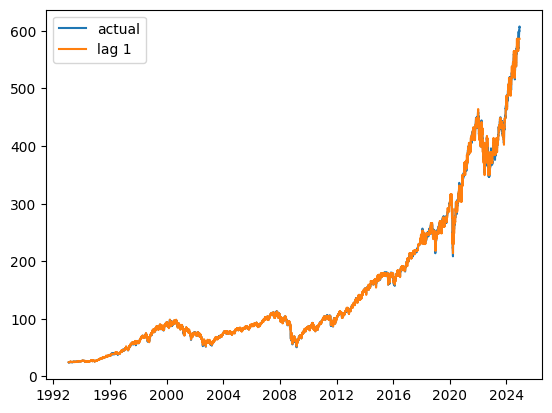

In [4]:
plt.plot(df_week_test['date'], df_week_test['close_price'], label='actual')
plt.plot(df_week_test['date'], close1_price, label='lag 1')
# plt.plot(df_week_test['date'],close2_price,label='lag 2')
# plt.plot(df_week_test['date'],close3_price,label='lag 3')
plt.legend()
plt.show()

The model does great on interpolation even when it was only trained on data at the start of the week. It still manages to accurately predict the other 6 unseen days.

In [5]:
log1 = XGBRegressor()
log1.fit(df_week[['log1']], df_week['log_return']) #X: [1-lagged log return]
log2 = XGBRegressor()
log2.fit(df_week[['log1', 'log2']], df_week['log_return']) #X: [1-lagged log return, 2-lagged log return]
log3 = XGBRegressor()
log3.fit(df_week[['log1', 'log2', 'log3']], df_week['log_return']) #X: [1-lagged log return, 2-lagged log return, 3-lagged log return]
log1_returns = log1.predict(df_week_test[['log1']])
log2_returns = log2.predict(df_week_test[['log1', 'log2']])
log3_returns = log3.predict(df_week_test[['log1', 'log2', 'log3']])
for i in range(1, len(log1_returns)): #cumulative sum to transform it from log returns back into predicted close price
    log1_returns[i] += log1_returns[i - 1]
    log2_returns[i] += log2_returns[i - 1]
    log3_returns[i] += log3_returns[i - 1]
initial_price = df_week_test.iloc[0]['close_price']
log1_price = log1_returns * initial_price
log2_price = log2_returns * initial_price
log3_price = log3_returns * initial_price
print('Using log return')
print('1 lag:', mean_squared_error(log1_price, df_week_test['close_price']))
print('2 lag:', mean_squared_error(log2_price, df_week_test['close_price']))
print('3 lag:', mean_squared_error(log3_price, df_week_test['close_price']))

Using log return
1 lag: 4894.303528887026
2 lag: 23712.19695860014
3 lag: 11536.30655502875


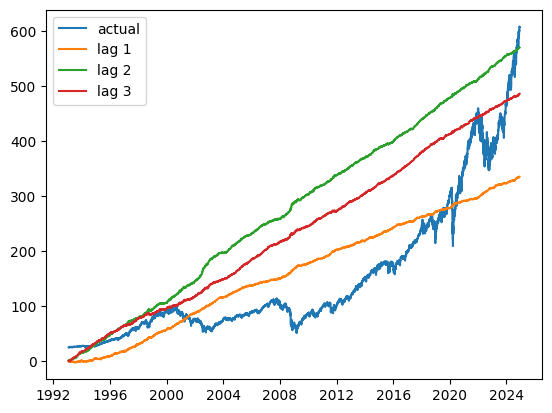

In [15]:
plt.plot(df_week_test['date'], df_week_test['close_price'], label='actual')
plt.plot(df_week_test['date'], log1_price, label='lag 1')
plt.plot(df_week_test['date'], log2_price,label='lag 2')
plt.plot(df_week_test['date'], log3_price,label='lag 3')
plt.legend()
plt.show()

As the models were trained on weekly data, it will tend to learn longer term trends rather than short term fluctuations. However, the lines are almost the same as straight lines, making the results not useful, if a complex model is learning simply a linear trend.

In [7]:
future_weeks = 20 * 52  #20 years, 52 weeks each
lag1_future = close1_price
lag2_future = close2_price
lag3_future = close3_price
for i in range(future_weeks):
    lag1_future = np.append(lag1_future, close1.predict(lag1_future[-1].reshape(-1, 1)))
    lag2_future = np.append(lag2_future, close2.predict(lag2_future[-2:].reshape(-1, 2)))
    lag3_future = np.append(lag3_future, close3.predict(lag3_future[-3:].reshape(-1, 3)))

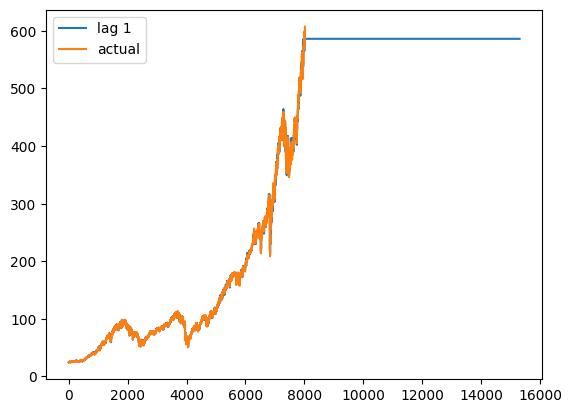

In [8]:
n = len(df_week_test)
x = [*range(n)] + [(i + 1) * 7 + n for i in range(future_weeks)] #Number of days since start
plt.plot(x, lag1_future, label='lag 1')
# plt.plot(x, lag2_future, label='lag 2')
# plt.plot(x, lag3_future, label='lag 3')
plt.plot([*range(n)], df_week_test['close_price'], label='actual')
plt.legend()
plt.show()

In [9]:
pd.concat([df_week_test['close_price'], pd.Series(close1_price), pd.Series(close2_price), pd.Series(close3_price)],
          axis=1) #To compare the results to the original series, and see why does it predict a straight line

,close_price,0,1,2
0,24.61,24.781225,24.783337,24.761969
1,24.78,25.058186,25.101135,25.143774
2,24.84,25.058186,25.159912,24.455713
3,25.10,25.058186,25.159912,25.422834
4,25.20,24.982666,24.811359,25.367348
...,...,...,...,...
8016,602.55,586.251343,586.711670,589.630615
8017,603.63,586.251343,586.711670,589.630615
8018,603.91,586.251343,586.711670,589.630615
8019,607.66,586.251343,586.711670,589.630615


When making predictions for a future day, and then using that prediction as a feature for predicting even further into the future, autoregressive models will end up predicting a straight line. Take for instance an ARMA model, when it is making future predictions, the error is assumed to be 0 as we do not know the actual value yet, and the MA component does not play a part in the predictions. Then, the predictions will converge onto the mean of the AR process, resulting in a straight line.

In [10]:
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': randint(1, 11),
#     'eta': uniform(loc=0, scale=0.5)
# }
# xgb = XGBRegressor()
# search = RandomizedSearchCV(xgb, param_dist, random_state=42).fit(df_month.drop(columns=['simple_return', 'date']), df_month['simple_return'])

In [11]:
# best_model = search.best_estimator_
# best_model.predict(df_month_test.drop(columns=['simple_return', 'date']))

In [12]:
# param_dist = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': randint(1, 11),
#     'eta': uniform(loc=0, scale=0.5)
# }
# xgb = XGBRegressor()
# search = RandomizedSearchCV(xgb, param_dist, random_state=42).fit(df_week.drop(columns=['simple_return', 'date']), df_week['simple_return'])

In [13]:
# best_model = search.best_estimator_
# best_model.predict(df_week_test.drop(columns=['simple_return', 'date']))